In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math


e = math.e #euler's number

In [ ]:
#we will be building micrograd from scratch
class value:
    def __init__(self, data, children = (), op='', label =""):
        self.data = data
        self.children = set(children)
        self.grad = 0 # grad is 0 by default
        self._backward = lambda : None #empty lambda function by default
        self.op = op
        self.label = label
    
    def __add__(self,other):
        out = value(self.data + other.data, children=(self, other), op='+')
        # _backward primarily talks about how the gradient would flow back.
        def _backward():
            #basically chain rule, lets say for example:
            # there is L -> Z -> X+Y 
            # now how tweaking x or y is going to affect L depends on
            # ∂L/∂z * ∂z/∂x = ∂L/∂x this is basically simple chain rule, and we know that 
            # ∂z/∂x = 1. by derivative
            # (f(x+h) - f(x)) / h 
            self.grad += out.grad * 1 #we do += to coz we want the gradient to accumulate when the same node is used more than once,
            #instead of fucking replacing it, like we were doing before.
            other.grad += out.grad * 1
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, value) else value(other) #to still continue to work if the other shit isnt a value object and a normal number.
        out = value(self.data * other.data, (self, other), '*')

        def _backward():
            # same chain rule bs
            self.grad += other.data * out.grad #the derivative would return eh other.data u understand the rest.
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    def tanh(self):
        out = value (( np.float_power(e , self.data) - np.float_power(e , -self.data) ) / (np.float_power(e , self.data) + np.float_power(e , -self.data) ), children=(self,), op='tanh')
        def _backward():
            self.grad += (1 - out.data**2) * out.data
        out._backward = _backward
        return out

    def backward(self):
        #topological order all of the children in the graph
        topo = []
        visited = set()

        def build_topo(root):
            if root not in visited:
                visited.add(root)
                for child in root.children:
                    build_topo(child)
                topo.append(root)

        # ultimate goal is to check how much a nudge of a node would affect the result.
        # this wil give gradient to all the nodes. this will apply chain rule to all the nodes.
        # notice the difference of _backward and backward. this is beautiful
        build_topo(self)
        self.grad = 1
        
        for node in reversed(topo):
            node._backward()
    
    

In [26]:
def trace(root):
    nodes = []
    edges = []
    visited = set()

    def build(v):
        if v not in visited:
            visited.add(v)
            # visit children first (so inputs appear on the left)
            for child in v.children:
                edges.append((child, v))
                build(child)
            nodes.append(v)

    build(root)
    return nodes, edges

In [27]:
from graphviz import Digraph

def draw_dot(root):
  # add a bit more spacing and keep left-to-right layout
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR', 'nodesep': '0.25', 'ranksep': '0.5'})

  nodes, edges = trace(root)

  # nodes is a topologically ordered list (inputs first); create nodes in that order
  for n in nodes:
    uid = str(id(n))
    # create a record-style node with data and grad (if present)
    grad_val = getattr(n, 'grad', 0.0)
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, grad_val), shape='record')
    if n.op:
      # op node sits between its children and the value node
      dot.node(name = uid + n.op, label = n.op)
      dot.edge(uid + n.op, uid)

  # edges list preserves traversal order
  for src, dst in edges:
    # connect source value to destination op node (dst.op)
    dot.edge(str(id(src)), str(id(dst)) + dst.op)

  return dot

In [44]:
w1 = value(0.2, label='w1')
bias = value(-0.5, label='bias')
x1 = value(1.0, label='x1') # input
x2 = value(2.0, label='x2') # input
w2 = value(-0.5, label='w2')    

out = (x1 * w1) + (x2 * w2) + bias
out = out.tanh()

out.backward()

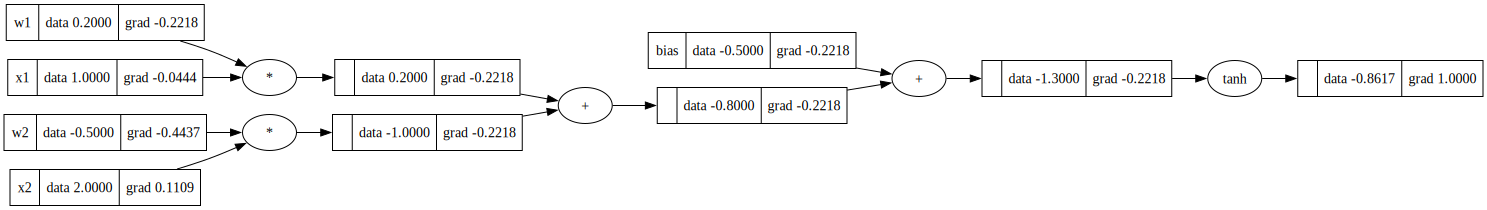

In [ ]:
draw_dot(out)

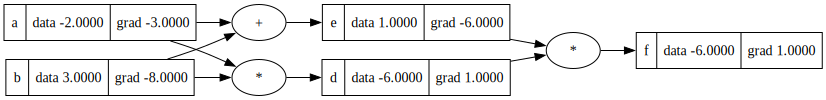

In [50]:
a = value(-2.0, label='a')
b = value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [ ]:
#just printing it out.
visited = set()
lst = []

def build(root):
    if root not in visited:
        visited.add(root)
        for child in root.children:
            build(child)

build(out)


for v in visited:
    print(v.label ,"the value is: ", v.data,  " the grad of this is : " , v.grad)

 the value is:  -0.8617231593133063  the grad of this is :  1
x2 the value is:  2.0  the grad of this is :  0.11091807378755703
 the value is:  -1.0  the grad of this is :  -0.22183614757511405
 the value is:  0.2  the grad of this is :  -0.22183614757511405
x1 the value is:  1.0  the grad of this is :  -0.04436722951502281
w2 the value is:  -0.5  the grad of this is :  -0.4436722951502281
 the value is:  -1.3  the grad of this is :  -0.22183614757511405
w1 the value is:  0.2  the grad of this is :  -0.22183614757511405
bias the value is:  -0.5  the grad of this is :  -0.22183614757511405
 the value is:  -0.8  the grad of this is :  -0.22183614757511405
